In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline
import os, time

pd.set_option('display.max_columns', None)
import plotly.express as px

In [2]:
from IPython.display import HTML

In [3]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [4]:
df_shelv = pd.read_excel('shelving.xlsx')
df_shelv.rename(columns={'Location':'DSP_LOCN','Unnamed: 1':'Shelving'},inplace=True)
df_shelv.head()

,DSP_LOCN,Shelving
0,4S00010101,SHELVING
1,4S00010102,SHELVING
2,4S00010103,SHELVING
3,4S00010104,SHELVING
4,4S00010105,SHELVING


In [5]:
df_S_NS = pd.read_csv('exportFG_FOC.csv')
df_S_NS.head()

,ITEM_NAME,SALE_GRP
0,S1442800,S
1,S1442801,S
2,S1532600,S
3,S1663800,S
4,S1663801,S


In [6]:
df_FPE = pd.read_excel('FPE.xlsx')
df_FPE.rename(columns={'DSP_LOCN':'Loc'},inplace=True)
df_FPE.rename(columns={'Location':'DSP_LOCN'},inplace=True)
df_FPE.head()

,DSP_LOCN,Level,Aisle,Bay,Side,Level.1,Position,HP/FP,FPE,Velocity,Loc,Arrow Direction,PICKING SEQ RACKING,PutAway Sequence RACKING,LOCN_CLASS,Active/Reserve,LENGTH,WIDTH,HEIGTH,Code(Reserve Loc),Putaway Zone(Reserve Loc),countif,Unnamed: 22
0,4P02011001,4,2,1,Odd,10,1,FP,1.0,B,4-P-02-01-10-01,UP,PK00001,NaN,R,Reserve,120,100,120,OVR,SG9LTOVR-OVERFLOW,1,NaN
1,4P02011002,4,2,1,Odd,10,2,FP,1.0,B,4-P-02-01-10-02,UP,PK00002,NaN,R,Reserve,120,100,120,OVR,SG9LTOVR-OVERFLOW,1,NaN
2,4P02011003,4,2,1,Odd,10,3,FP,1.0,B,4-P-02-01-10-03,UP,PK00003,NaN,R,Reserve,120,100,120,OVR,SG9LTOVR-OVERFLOW,1,NaN
3,4P02011203,4,2,1,Odd,12,3,FP,1.0,B,4-P-02-01-12-03,UP,PK00004,NaN,R,Reserve,120,100,120,OVR,SG9LTOVR-OVERFLOW,1,NaN
4,4P02011202,4,2,1,Odd,12,2,FP,1.0,B,4-P-02-01-12-02,UP,PK00005,NaN,R,Reserve,120,100,120,OVR,SG9LTOVR-OVERFLOW,1,NaN


In [7]:
path = "C:\\Users\\btg168\\Desktop\\Inventory reports test\\"
d_init={}

for file in os.listdir(path):
    d_init[file] = pd.read_excel(path+file)
    d_init[file]['Date File created'] = time.ctime(os.path.getmtime(path+file))
    d_init[file]['Date File created'] = pd.to_datetime(d_init[file]['Date File created'])
    d_init[file]['Date File created'] = d_init[file]['Date File created'].dt.date


In [8]:
df_concat_raw = pd.concat(d_init.values())

In [10]:
df_concat_raw.dtypes

COMPANY_NAME          object
WHSE                  object
LPN_STATUS            object
REF_FIELD1            object
MERCH_TYPE            object
CODE_DESC             object
TC_LPN_ID             object
DSP_LOCN              object
EAN                    int64
ITEM_NAME             object
ZINDEX                 int64
DESCRIPTION           object
INVENTORY_TYPE        object
ON_HAND_QTY            int64
WM_ALLOCATED_QTY       int64
AVAILABLE_QTY          int64
BATCH_NBR             object
MANUFACTURED_DTTM     object
RECEIVED_DTTM         object
EXPIRATION_DATE       object
STOCK_AGE_DAYS       float64
AGEING_DAYS          float64
PROD_LIFE_IN_DAY     float64
LAST_UPDATED_DTTM     object
STD_PACK_QTY           int64
TC_ASN_ID             object
Date File created     object
dtype: object

In [11]:
df_concat_raw.shape

(1969220, 27)

In [15]:
df_concat_raw['DSP_LOCN'].unique()

array(['4S05460901', '6P01190402', '4P10251601', ..., '6STAGE0406',
       '6STAGE0404', '6STAGE0409'], dtype=object)

In [16]:
df_concat_filtered = df_concat_raw.merge(df_shelv,on='DSP_LOCN',how='left')
df_concat_filtered = df_concat_filtered.merge(df_S_NS,on='ITEM_NAME',how='left' )
df_concat_filtered = df_concat_filtered.merge(df_FPE[['DSP_LOCN','HP/FP']],on='DSP_LOCN',how='left' )
df_concat_filtered.dropna(subset=['DSP_LOCN'],inplace=True)
df_concat_filtered[['REF_FIELD1']] = df_concat_filtered['REF_FIELD1'].replace(to_replace=\
                                                                          ['HR','R. LAUREN','URBAN DECAY','KERASTASE',\
                                                                           'SKINCEUTICALS','Martin MARGIELA','VICHY',\
                                                                           'Atelier Cologne','VIKTOR ET ROLF',\
                                                                           'ROCHE POSAY','HOUSE 99',\
                                                                           'IMARQUES INTER-DEPARTMENT','CLARISONIC']\
                                                                          ,value = 'Mixed Brands')
df_concat_filtered['to keep'] = df_concat_filtered['DSP_LOCN'].apply(lambda x: False if len(x)-sum(c.isdigit() for c in x)>2 else True)
df_concat_filtered = df_concat_filtered.loc[(df_concat_filtered.DSP_LOCN.str[:2] != 'LT')\
                                        & (df_concat_filtered['INVENTORY_TYPE']=='U') & (df_concat_filtered['ZINDEX']==1)\
                                        & (df_concat_filtered['Shelving'].isna()) & (df_concat_filtered['to keep']== True)\
                                        & (df_concat_filtered.DSP_LOCN.str[:1] == '4')\
                                        & (df_concat_filtered['REF_FIELD1'] != "L'OREAL PARIS")]
df_concat_filtered = df_concat_filtered[['REF_FIELD1','DSP_LOCN','ITEM_NAME','SALE_GRP','Date File created','HP/FP']]

# Evolution of brands' ratio occupancy over the time

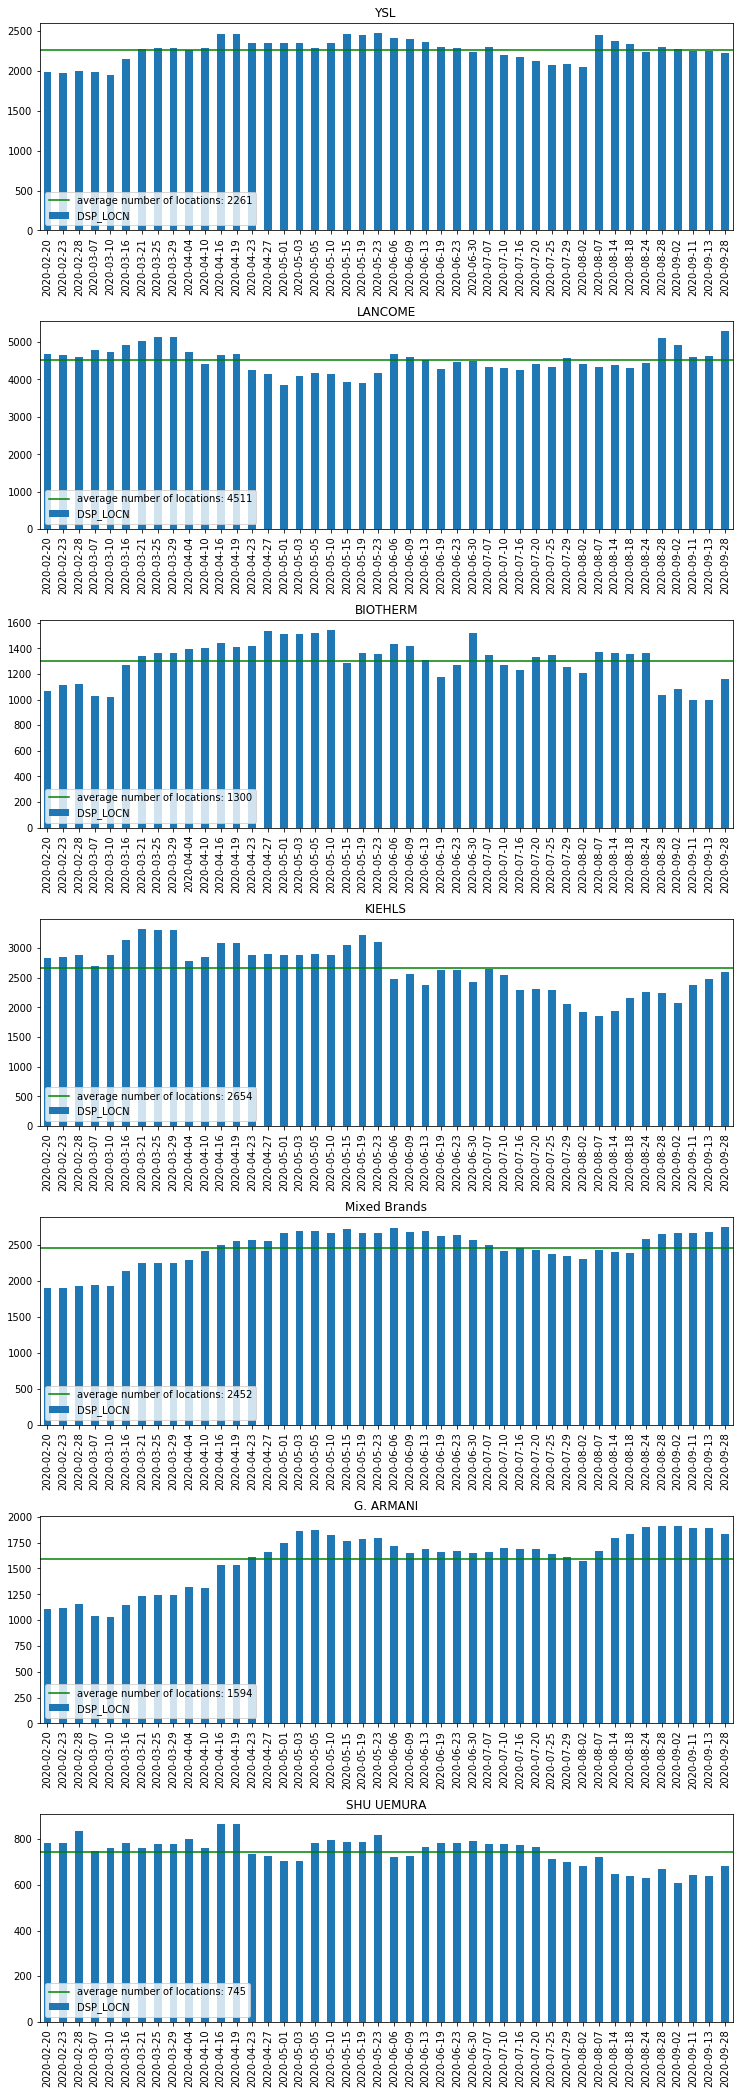

In [17]:
fig,axes = plt.subplots(len(df_concat_filtered['REF_FIELD1'].unique()),figsize=(12,30))
fig.tight_layout(pad=7.0)
i = 0

for ref in list(df_concat_filtered['REF_FIELD1'].unique()):
    df_plot = df_concat_filtered[df_concat_filtered['REF_FIELD1'] ==f'{ref}'].groupby(['REF_FIELD1','Date File created'])[['DSP_LOCN']].nunique().reset_index()
    df_plot = df_plot[['REF_FIELD1','DSP_LOCN','Date File created']]
    df_plot.plot(kind='bar',ax=axes[i],x='Date File created')
    axes[i].set_xlabel('')
    axes[i].axhline(y=df_plot['DSP_LOCN'].mean(), color='g',label = f"average number of locations: {round(df_plot['DSP_LOCN'].mean())}")
    axes[i].legend(loc ='lower left')
    axes[i].set_title(f"{ref}")
    
    i+=1
    

In [18]:
data = {'Mixed Brands':[770*2],'BIOTHERM':[798+693]\
        ,'SHU UEMURA':[728+462],'YSL':[462+847+847],'G. ARMANI':[882+770],\
        'KIEHLS':[770+840+770+770+798],'LANCOME':[693+728+756+735+693+798+684],"L'OREAL PARIS":[846*2+539*2+756+692+315]}
df_master = pd.DataFrame(data,columns=data.keys()).T
df_master.reset_index(inplace=True)
df_master.rename(columns={'index':'REF_FIELD1'},inplace=True)
df_master.rename(columns={df_master.columns[-1]:'Max Occupancy'},inplace=True)
#master from Vincent LAU
# print('\nMaster location from Vincent LAU')
print('\nMaster location from Vincent SIA \nLocation wise (no FPE)')
df_master


Master location from Vincent SIA 
Location wise (no FPE)


,REF_FIELD1,Max Occupancy
0,Mixed Brands,1540
1,BIOTHERM,1491
2,SHU UEMURA,1190
3,YSL,2156
4,G. ARMANI,1652
5,KIEHLS,3948
6,LANCOME,5087
7,L'OREAL PARIS,4533


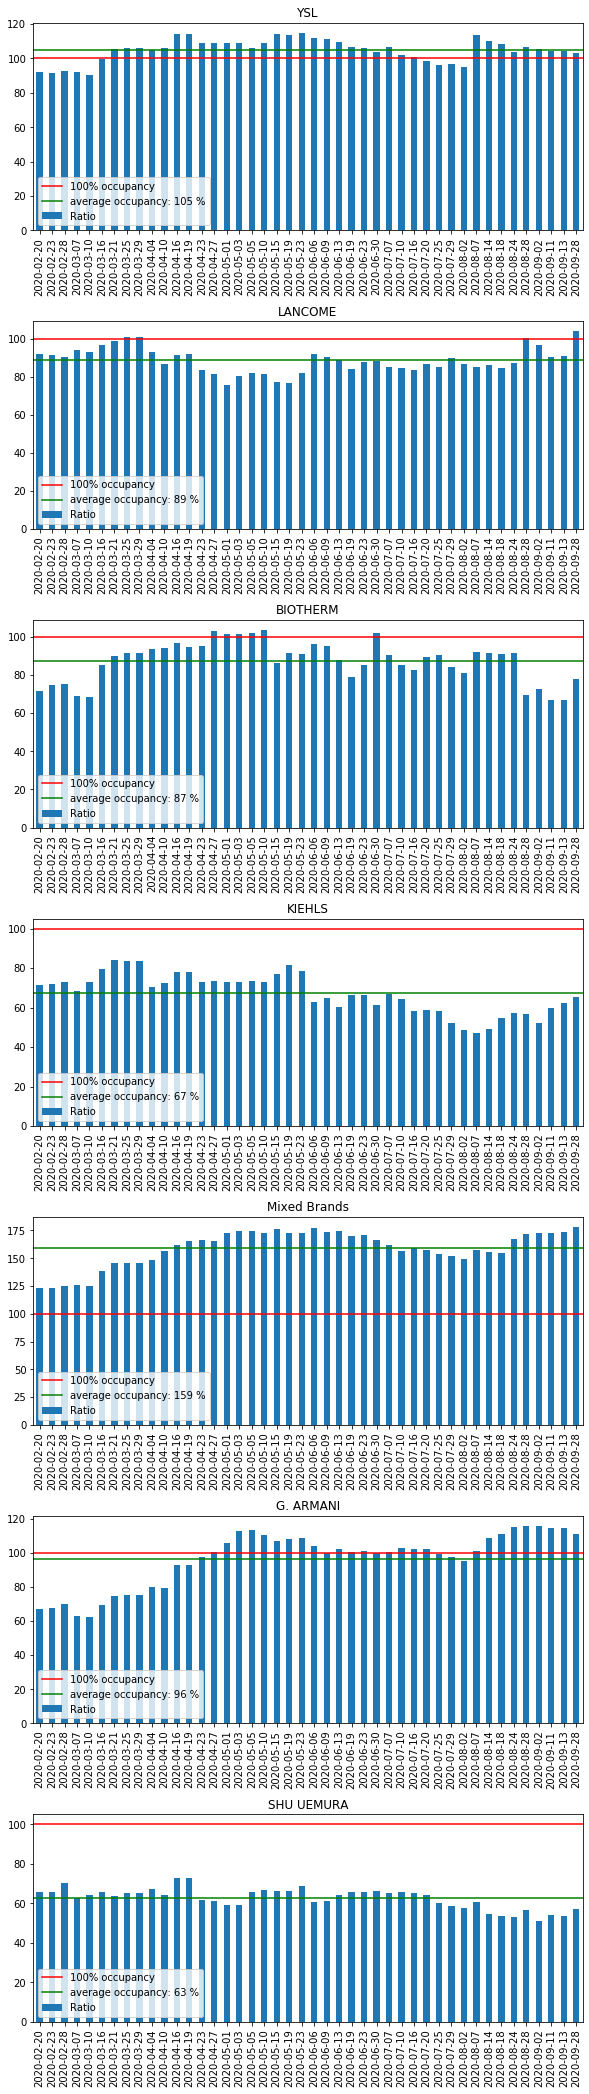

In [20]:
fig,axes = plt.subplots(len(df_concat_filtered['REF_FIELD1'].unique()),figsize=(10,30))
fig.tight_layout(pad=7.0)
i = 0

for ref in list(df_concat_filtered['REF_FIELD1'].unique()):
    df_plot = df_concat_filtered[df_concat_filtered['REF_FIELD1'] =='{}'.format(ref)].groupby(['REF_FIELD1','Date File created'])[['DSP_LOCN']].nunique().reset_index()
    df_plot = df_plot.merge(df_master, on='REF_FIELD1', how='left')
    df_plot['Ratio'] = df_plot.apply(lambda x: x['DSP_LOCN']*100/x['Max Occupancy'], axis=1)
    df_plot = df_plot[['REF_FIELD1','Ratio','Date File created']]
    df_plot.plot(kind='bar',ax=axes[i],x='Date File created')
    axes[i].set_xlabel('')
    axes[i].axhline(y=100, color='r',label='100% occupancy')
    axes[i].axhline(y=df_plot['Ratio'].mean(), color='g',label = f"average occupancy: {round(df_plot['Ratio'].mean())} %")
    axes[i].legend(loc ='lower left')
    axes[i].set_title(f"{ref}")
    
    i+=1
    